In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql.types import *
from pyspark import SparkContext
from pyspark.sql import SQLContext 
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler
import logging

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Spark_RandomForestRegression_Ener00.com") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.utils import AnalysisException
import os
spark.sparkContext.setLogLevel("ERROR")
logging.getLogger("py4j").setLevel(logging.ERROR)


main_folder = '/Volumes/G Drive/enertalk/00'

# Create a dictionary to store the appliance data
appliance_data = {}

# Iterate over subfolders in the main folder
for subfolder in os.listdir(main_folder):
    if subfolder == '.DS_Store':
        continue

    subfolder_path = os.path.join(main_folder, subfolder)

    if not os.path.isdir(subfolder_path):
        continue

    try:
        # Load the washing machine data
        washing_machine_files = [file for file in os.listdir(subfolder_path) if 'washing-machine' in file and file.endswith('.parquet.gzip')]
        for file in washing_machine_files:
            file_path = os.path.join(subfolder_path, file)
            appliance_name = file.split('_')[1].split('.')[0]
            washing_machine_data = spark.read.parquet(file_path)
            appliance_data[appliance_name] = washing_machine_data

        # Load the rice cooker data
        rice_cooker_files = [file for file in os.listdir(subfolder_path) if 'rice-cooker' in file and file.endswith('.parquet.gzip')]
        for file in rice_cooker_files:
            file_path = os.path.join(subfolder_path, file)
            appliance_name = file.split('_')[1].split('.')[0]
            rice_cooker_data = spark.read.parquet(file_path)
            appliance_data[appliance_name] = rice_cooker_data

        # Load the total data
        total_files = [file for file in os.listdir(subfolder_path) if 'total' in file and file.endswith('.parquet.gzip')]
        for file in total_files:
            file_path = os.path.join(subfolder_path, file)
            appliance_name = file.split('_')[1].split('.')[0]
            total_data = spark.read.parquet(file_path)
            appliance_data[appliance_name] = total_data

        # Load the TV data
        tv_files = [file for file in os.listdir(subfolder_path) if 'TV' in file and file.endswith('.parquet.gzip')]
        for file in tv_files:
            file_path = os.path.join(subfolder_path, file)
            appliance_name = file.split('_')[1].split('.')[0]
            tv_data = spark.read.parquet(file_path)
            appliance_data[appliance_name] = tv_data

        # Load the microwave data
        microwave_files = [file for file in os.listdir(subfolder_path) if 'microwave' in file and file.endswith('.parquet.gzip')]
        for file in microwave_files:
            file_path = os.path.join(subfolder_path, file)
            appliance_name = file.split('_')[1].split('.')[0]
            microwave_data = spark.read.parquet(file_path)
            appliance_data[appliance_name] = microwave_data

        # Load the water purifier data
        water_pur_files = [file for file in os.listdir(subfolder_path) if 'water-purifier' in file and file.endswith('.parquet.gzip')]
        for file in water_pur_files:
            file_path = os.path.join(subfolder_path, file)
            appliance_name = file.split('_')[1].split('.')[0]
            water_pur_data = spark.read.parquet(file_path)
            appliance_data[appliance_name] = water_pur_data

        # Load the fridge data
        fridge_files = [file for file in os.listdir(subfolder_path) if 'fridge' in file and file.endswith('.parquet.gzip')]
        for file in fridge_files:
            file_path = os.path.join(subfolder_path, file)
            appliance_name = file.split('_')[1].split('.')[0]
            fridge_data = spark.read.parquet(file_path)
            appliance_data[appliance_name] = fridge_data
            
        kimchi_fridge_files = [file for file in os.listdir(subfolder_path) if 'kimchi-fridge' in file and file.endswith('.parquet.gzip')]
        for file in kimchi_fridge_files:
            kimchi_fridge_path = os.path.join(subfolder_path, file)
            kimchi_fridge_data = spark.read.parquet(kimchi_fridge_path)
            # Store the kimchi fridge data in the dictionary with the appliance name
            appliance_name = file.split('_')[1].split('.')[0]
            appliance_data[appliance_name] = kimchi_fridge_data

    except AnalysisException as e:
        # Handle the case when a file is not found
        print(f"Skipping folder {subfolder}: {e}")
        continue


In [3]:
from functools import reduce  
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.sql import DataFrame

join_data = {'wash': washing_machine_data, 'rice': rice_cooker_data, 'tv': tv_data, 'micro': microwave_data, 'water': water_pur_data, 
             'kimchi_fridge' : kimchi_fridge_data, 'fridge': fridge_data}

for i, df_name in join_data.items():
    globals()["data_" + i] = total_data.join(df_name, on='timestamp')
    globals()["data_" + i] = globals()["data_" + i].drop('timestamp', '__index_level_0__')
    globals()["data_" + i] = globals()["data_" + i].toDF('total_active_power', 'total_reactive_power',
                                                         i + '_active_power', i + '_reactive_power')
    for column in globals()["data_" + i].columns:
        globals()["data_" + i] = globals()["data_" + i].withColumn(column, col(column).cast(DoubleType()))


In [7]:
from pyspark.sql.functions import col

for i in ['wash', 'rice', 'tv', 'micro', 'water', 'kimchi_fridge', 'fridge']:
    
    globals()["data_" + i] =  globals()["data_" + i].dropna()
    globals()["data_" + i].show()
    print(globals()["data_" + i].count())
    
    print(globals()["data_" + i].printSchema())


+------------------+--------------------+-----------------+-------------------+
|total_active_power|total_reactive_power|wash_active_power|wash_reactive_power|
+------------------+--------------------+-----------------+-------------------+
|            360.22|               44.76|             0.01|               5.95|
|            382.05|               43.86|             0.04|               5.91|
|            386.41|               43.86|             0.06|               6.01|
|            386.98|               44.02|              0.1|               5.99|
|             386.2|               43.54|             0.05|               6.04|
|            386.45|               44.03|             0.12|               6.04|
|            387.11|               43.94|             0.03|               6.01|
|            386.97|                44.3|             0.07|               6.07|
|            387.42|               44.61|             0.04|               6.03|
|            386.74|                44.5

Metrics for wash - wash_active_power:
RMSE: 108.675781869371
MSE: 11810.425564919105
MAE: 24.27161142460158
R2: 0.9051261908706651


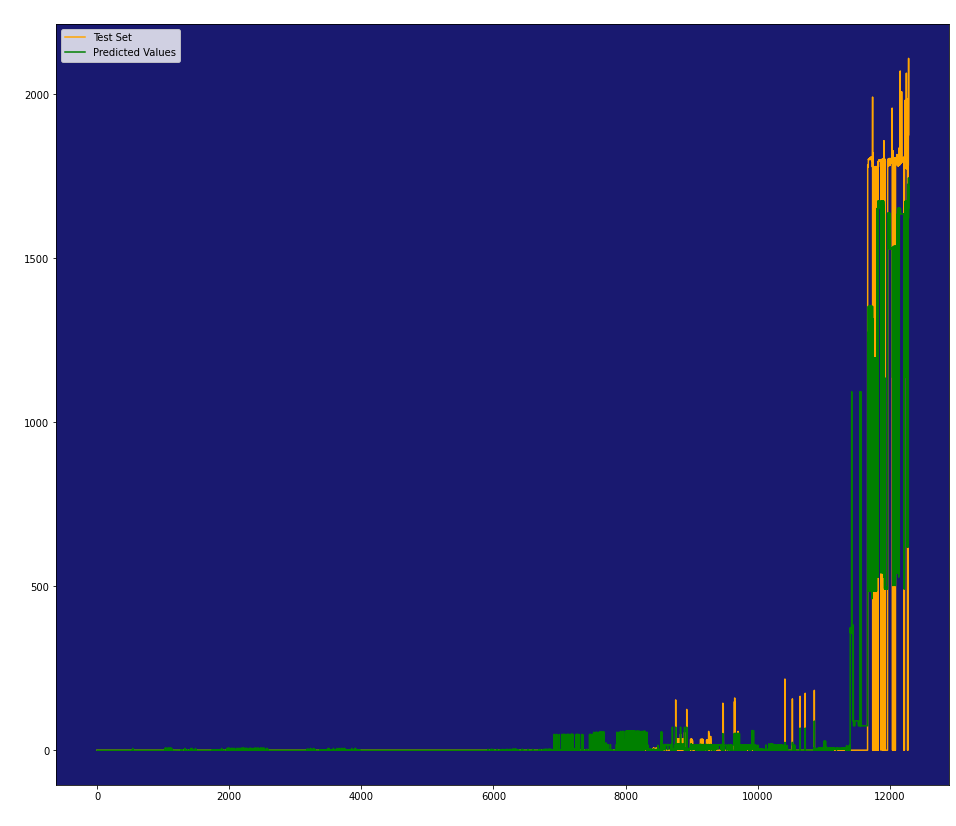

Metrics for wash - wash_reactive_power:
RMSE: 4.938961763465785
MSE: 24.393343300977058
MAE: 1.5020001513071082
R2: 0.6652356835819813


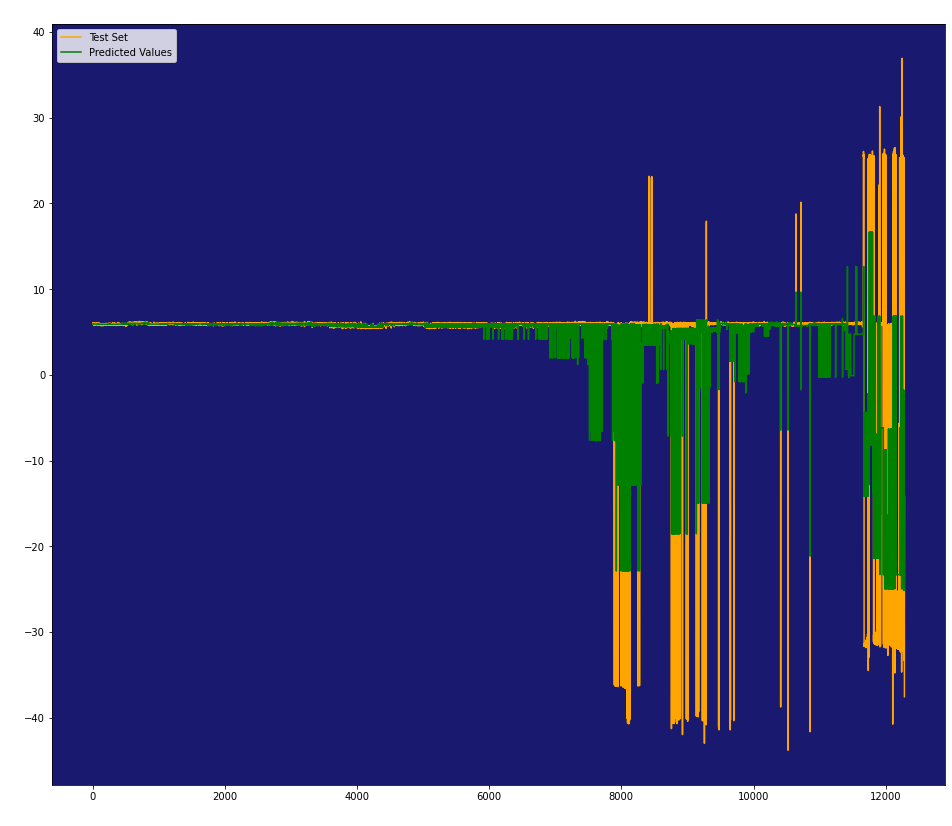

Metrics for tv - tv_active_power:
RMSE: 13.900470253715811
MSE: 193.22307327443812
MAE: 7.148158288303297
R2: 0.9078849938194626


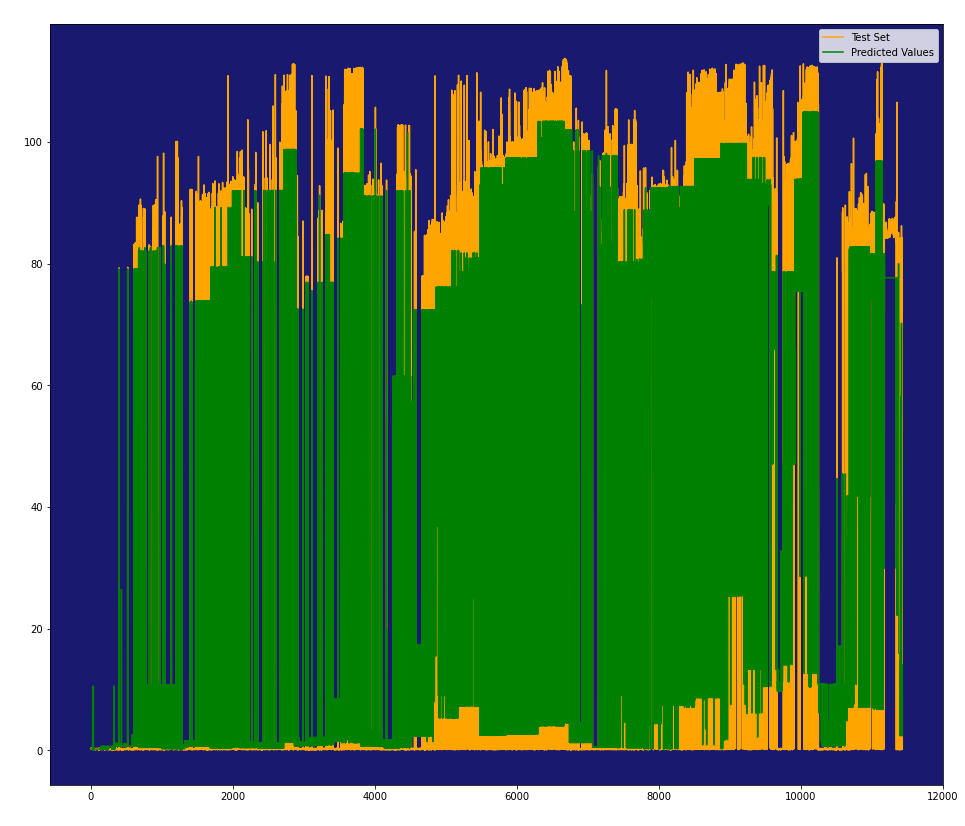

Metrics for tv - tv_reactive_power:
RMSE: 3.7533887664416423
MSE: 14.087927232050312
MAE: 1.8535595363434854
R2: 0.9073384232859882


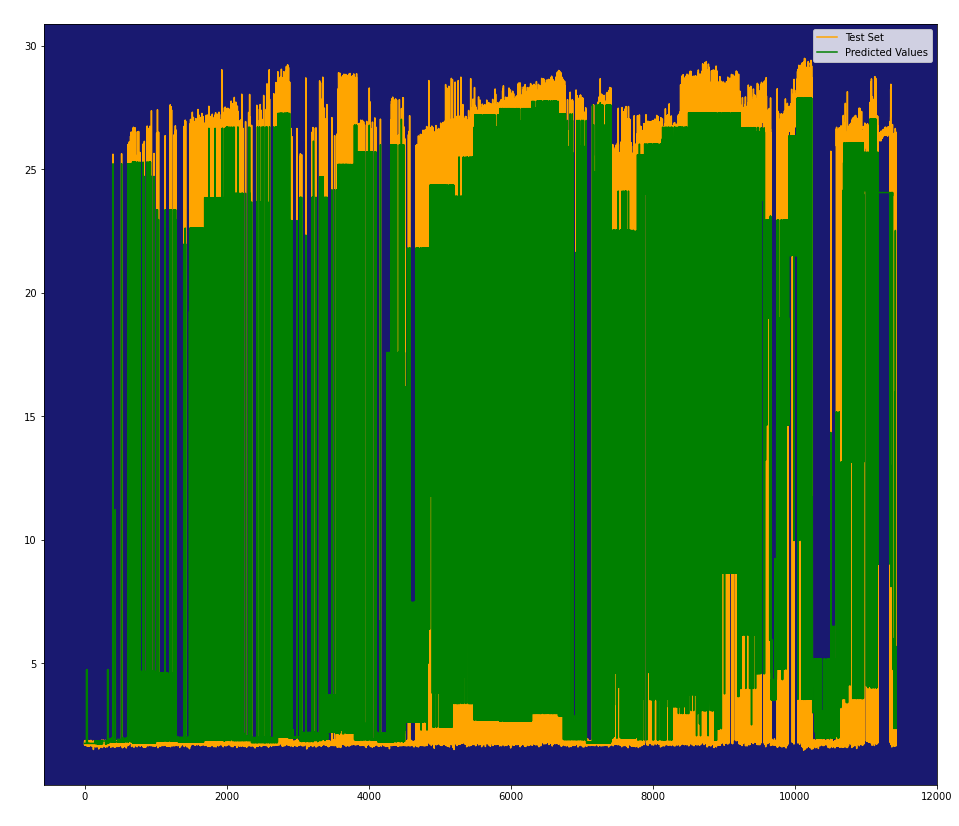

Metrics for micro - micro_active_power:
RMSE: 12.259796836123998
MSE: 150.302618463036
MAE: 0.7091403832812924
R2: 0.645703100126541


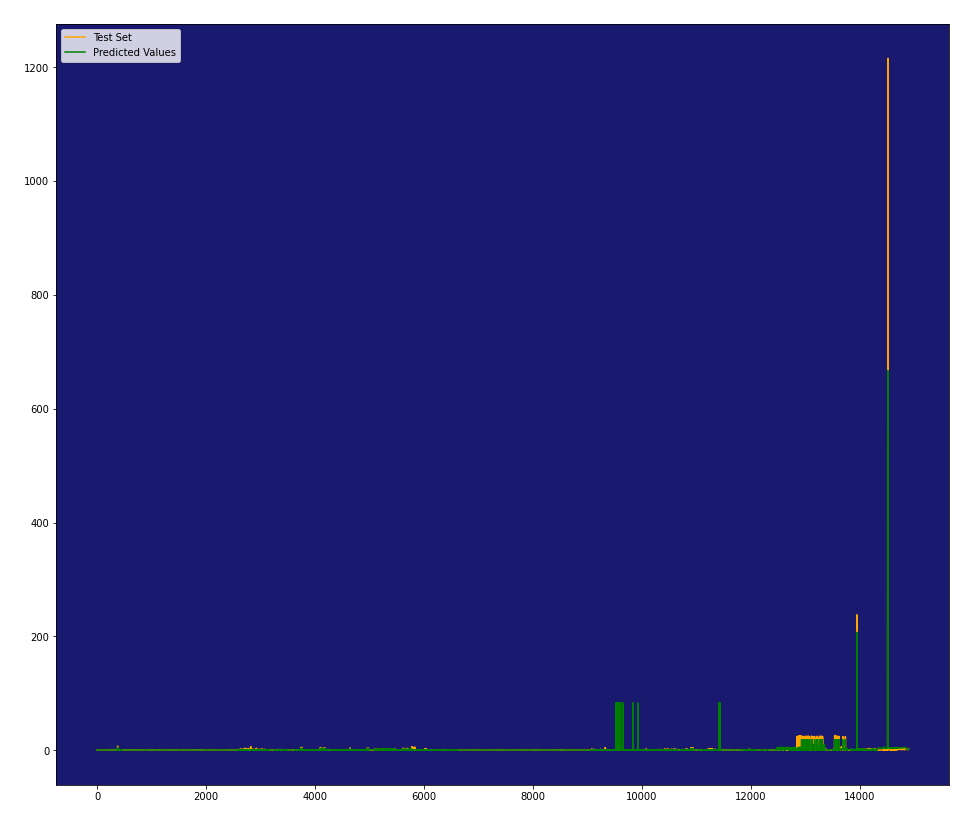

Metrics for micro - micro_reactive_power:
RMSE: 4.8554101255834965
MSE: 23.57500748761875
MAE: 0.23876001144326378
R2: 0.6967141446962315


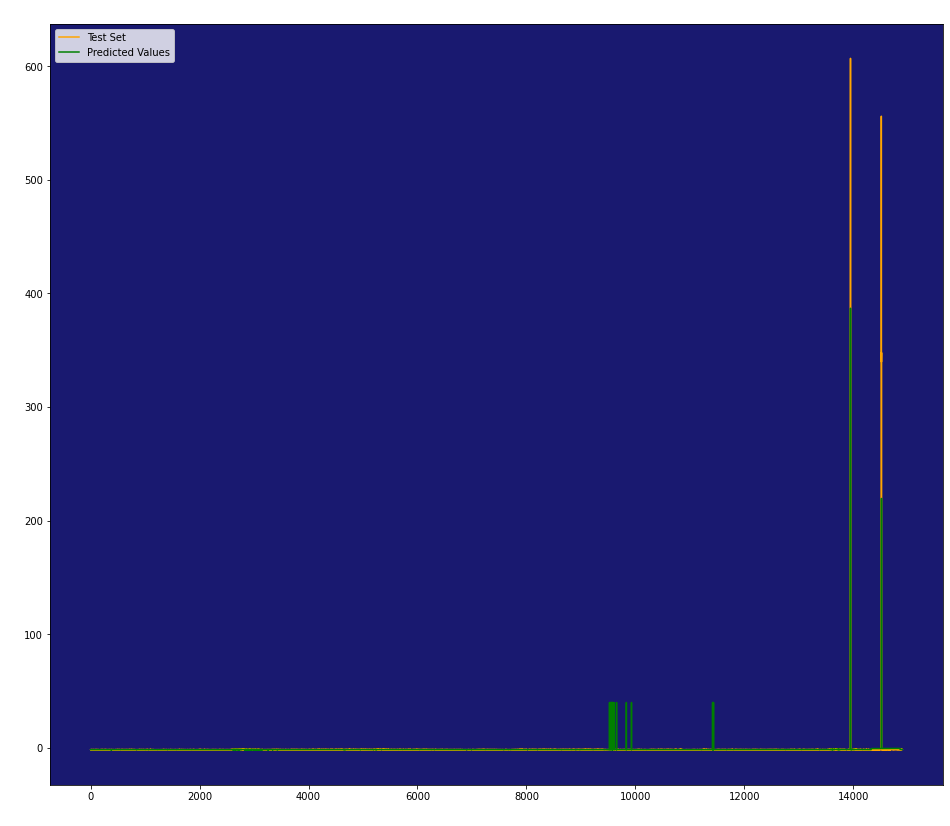

Metrics for water - water_active_power:
RMSE: 24.528980328039566
MSE: 601.670875933352
MAE: 5.745702914479583
R2: 0.8495022310261506


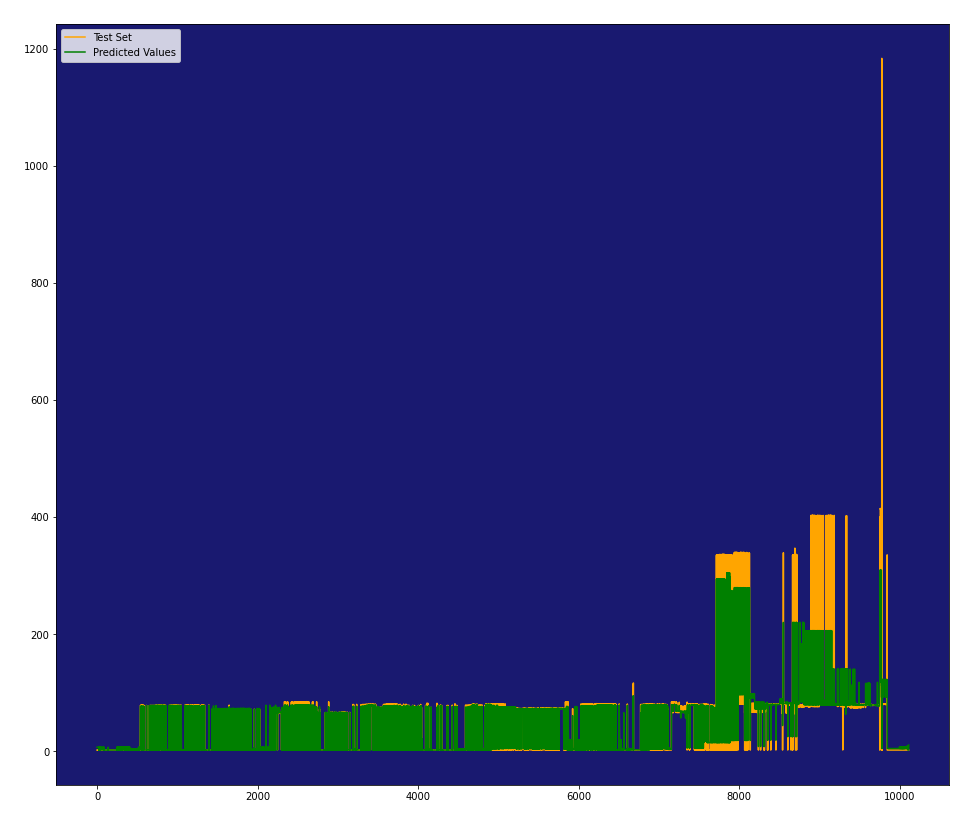

Metrics for water - water_reactive_power:
RMSE: 7.241498667511352
MSE: 52.439302951568685
MAE: 1.7872575970763434
R2: 0.9862693843813076


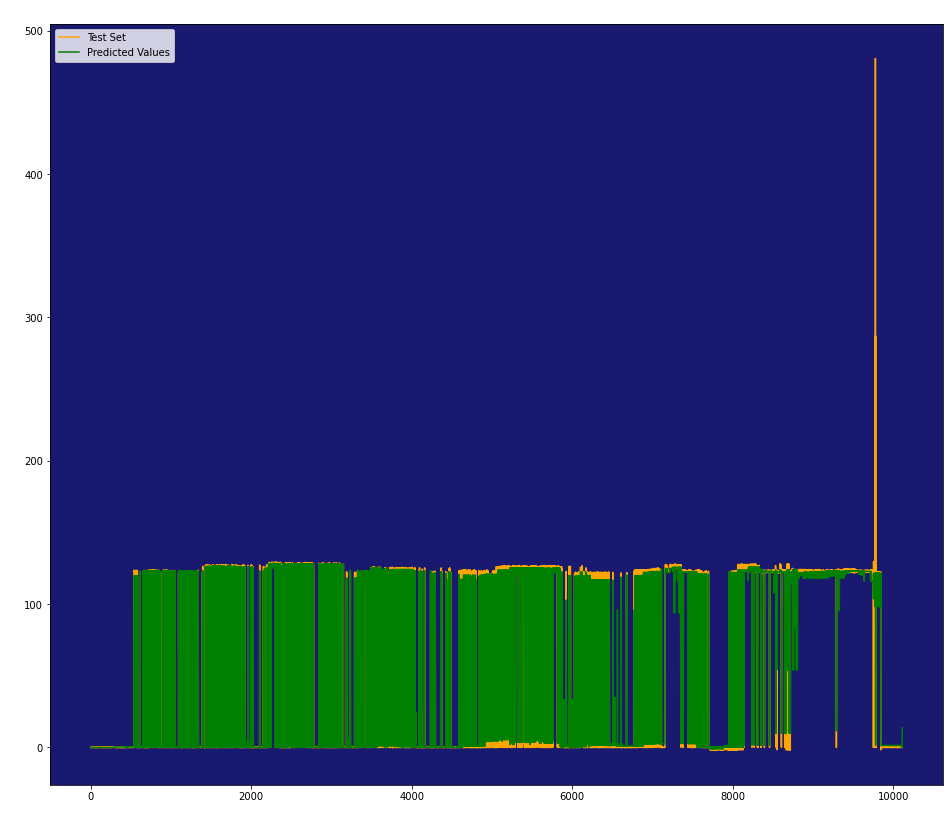

Metrics for rice - rice_active_power:
RMSE: 0.058320046606121244
MSE: 0.0034012278361401542
MAE: 0.046420859545586064
R2: 0.004370609682599724


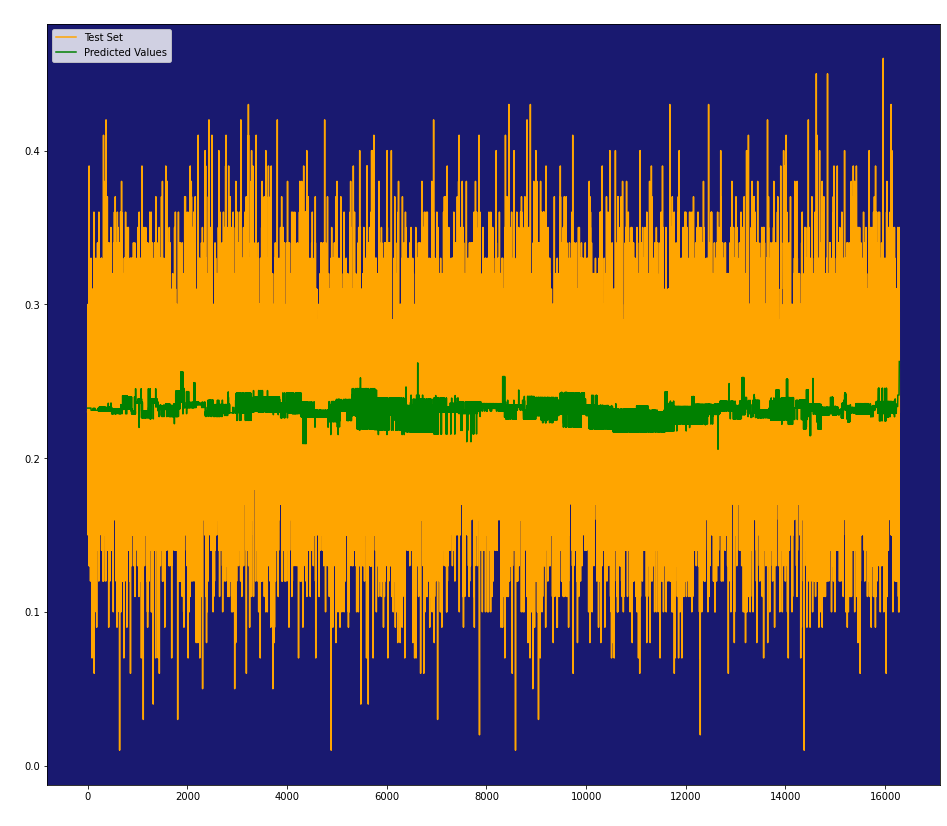

Metrics for rice - rice_reactive_power:
RMSE: 0.06121242542494953
MSE: 0.003746961026405007
MAE: 0.048664090071960826
R2: -0.0001938313548663917


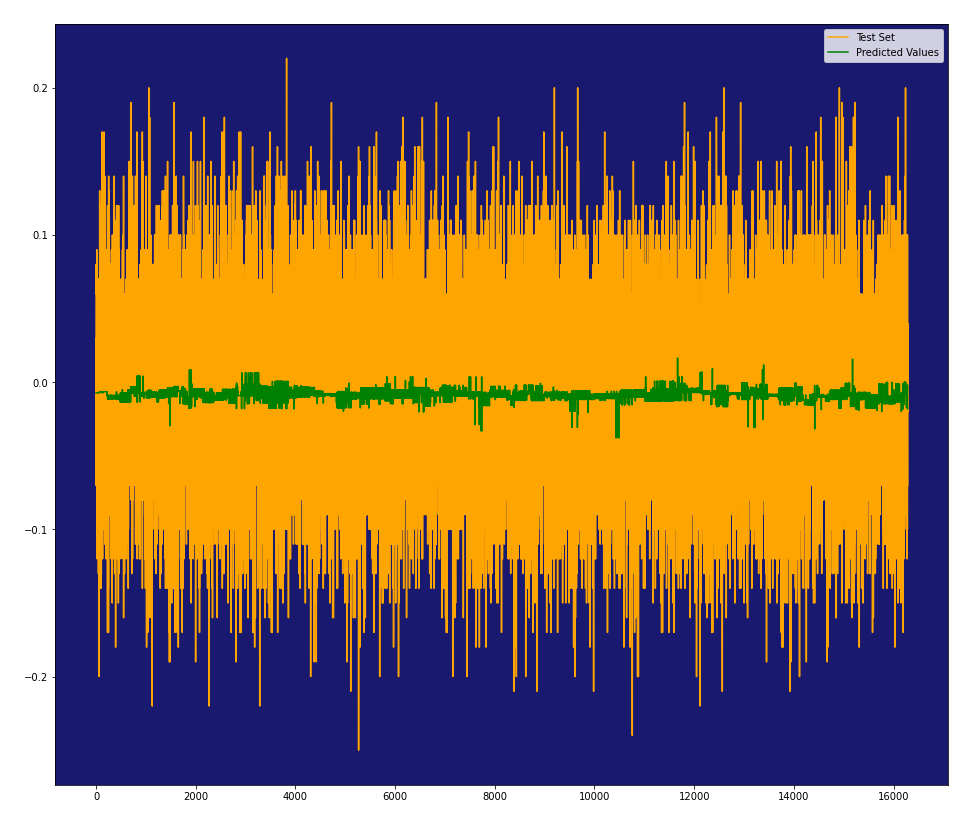

Metrics for fridge - fridge_active_power:
RMSE: 29.785630249007486
MSE: 887.1837693305898
MAE: 8.043930246832074
R2: 0.5096936908341778


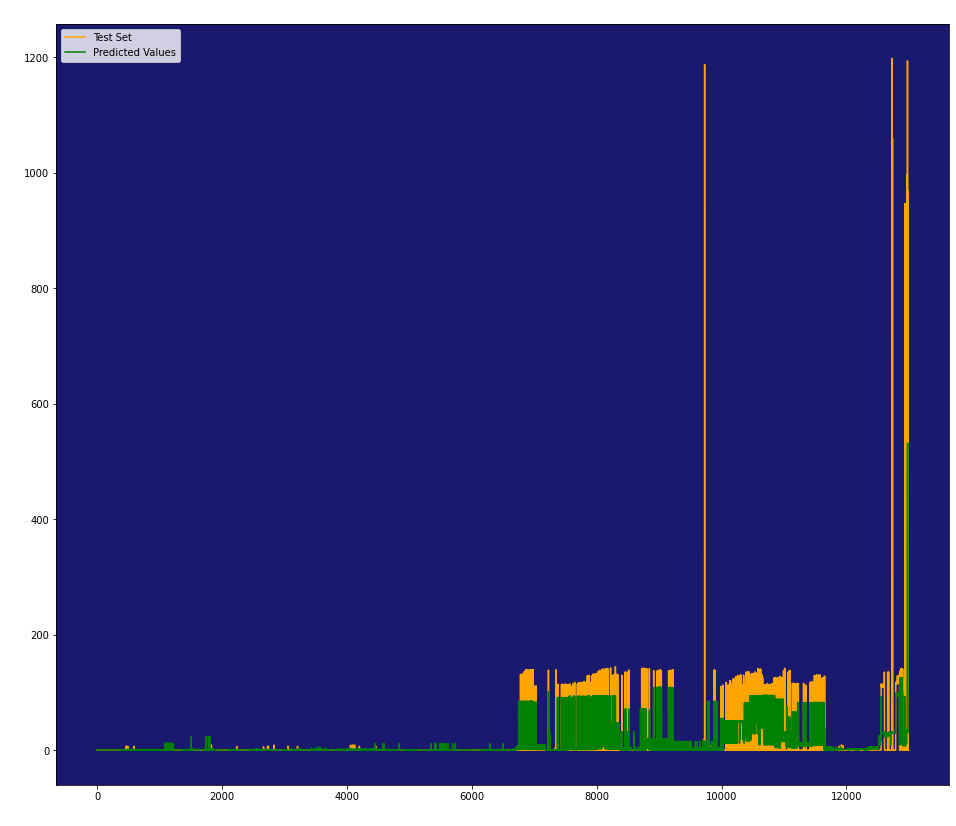

Metrics for fridge - fridge_reactive_power:
RMSE: 15.307827688099042
MSE: 234.32958852853167
MAE: 3.2482709825383687
R2: 0.4274157239561719


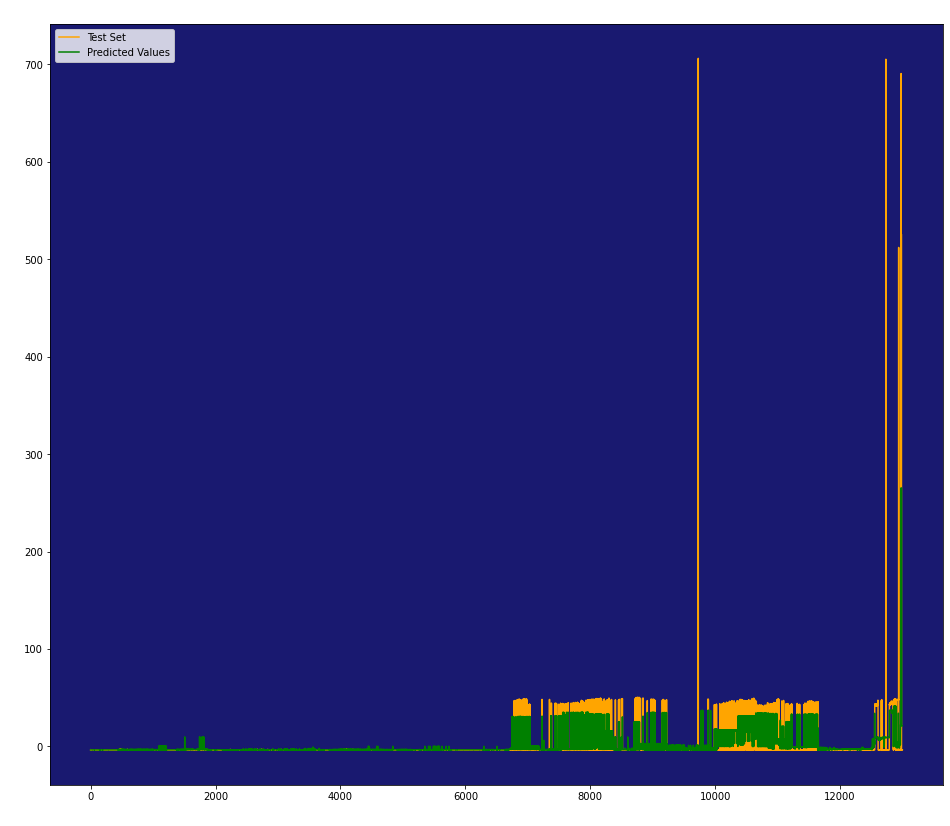

Metrics for kimchi_fridge - kimchi_fridge_active_power:
RMSE: 29.785630249007486
MSE: 887.1837693305898
MAE: 8.043930246832074
R2: 0.5096936908341778


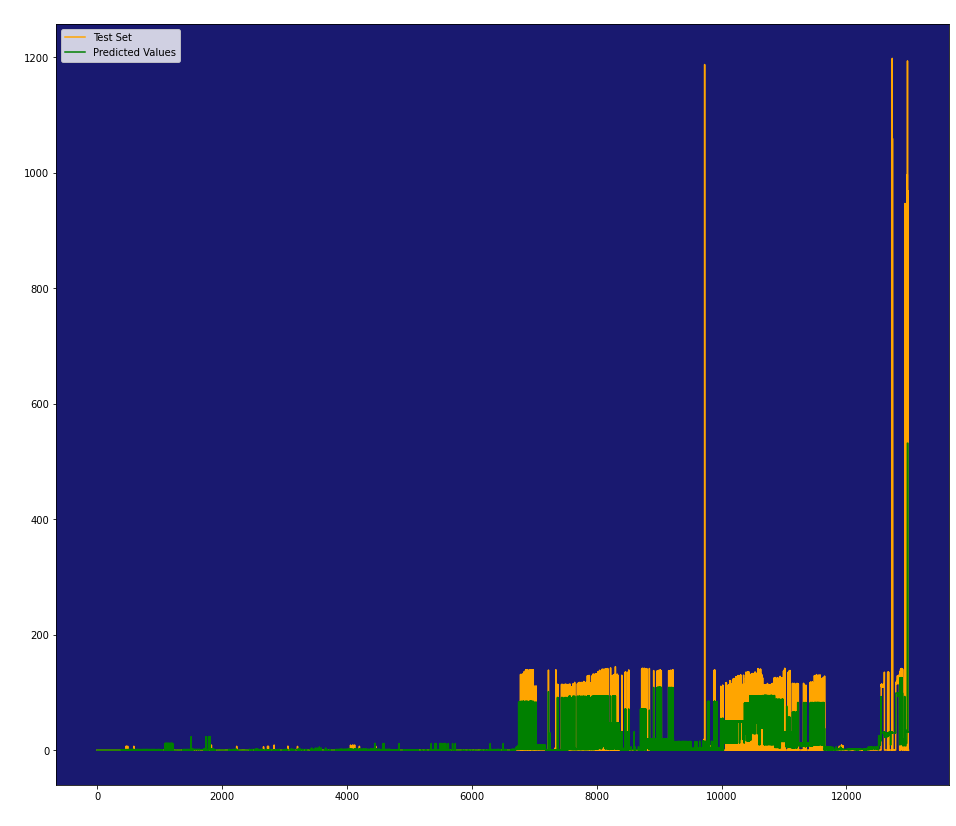

Metrics for kimchi_fridge - kimchi_fridge_reactive_power:
RMSE: 15.307827688099042
MSE: 234.32958852853167
MAE: 3.2482709825383687
R2: 0.4274157239561719


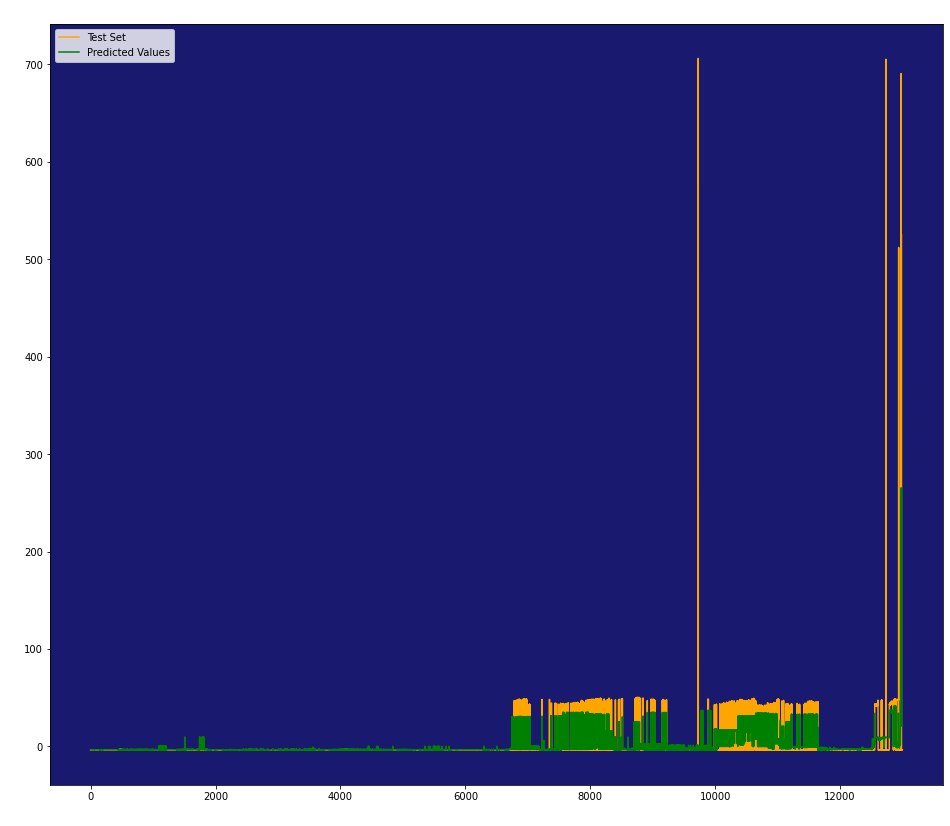

In [31]:
# Now we will implement 14 models that use each time the two total columns to predict the each column regarding each devices metrics,
# e.g. one model to predict the devices active power and another one for the appliances reactive power.... 14 train and test sets are made also 
# one for each devices specific feature

from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator

# Create dictionaries to hold the input and output column names for each device
input_cols = {'wash': ['total_active_power', 'total_reactive_power'],
              'tv': ['total_active_power', 'total_reactive_power'],
              'micro': ['total_active_power', 'total_reactive_power'],
              'water': ['total_active_power', 'total_reactive_power'],
              'rice': ['total_active_power', 'total_reactive_power'],
              'fridge':['total_active_power', 'total_reactive_power'],
               'kimchi_fridge':['total_active_power', 'total_reactive_power']}

output_cols = {'wash': ['wash_active_power', 'wash_reactive_power'],
               'tv': ['tv_active_power', 'tv_reactive_power'],
               'micro': ['micro_active_power', 'micro_reactive_power'],
               'water': ['water_active_power', 'water_reactive_power'],
               'rice': ['rice_active_power', 'rice_reactive_power'],
              'fridge':['fridge_active_power', 'fridge_reactive_power'],
               'kimchi_fridge':['kimchi_fridge_active_power', 'kimchi_fridge_reactive_power']}



# Create empty dictionaries to hold the pipeline models and predictions for each device
pipeline_models = {}
predictions = {}

train_data_list = []
test_data_list = []
trains = []
tests = []

i = 0
# Iterate over the devices
for device in ['wash', 'tv', 'micro', 'water', 'rice','fridge', 'kimchi_fridge']:
    # Get the input and output column names for the current device
    input_cols_device = input_cols[device]
    output_cols_device = output_cols[device]

    # Get the DataFrame for the current device
    df = globals()["data_" + device]

    # Split the data into train and test sets
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
    
    # Create empty lists to hold train and test datasets for each feature
    train_data_features = []
    test_data_features = []

    # Iterate over the output columns for the current device
    for output_col in output_cols_device:
        # Create vector assembler for input columns
        assembler = VectorAssembler(inputCols=input_cols_device, outputCol='features')

        # Create scaler
        scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

        # Create GBT regressor
        rf = RandomForestRegressor(featuresCol='scaled_features', labelCol=output_col, numTrees=100, maxDepth=20)

        # Create pipeline
        pipeline = Pipeline(stages=[assembler, scaler, rf])

        # Fit pipeline
        pipeline_model = pipeline.fit(train_data)

        # Make predictions on the test data
        predictions_device = pipeline_model.transform(test_data)

        # Add pipeline model and predictions to dictionaries
        if device not in pipeline_models:
            pipeline_models[device] = []
        pipeline_models[device].append(pipeline_model)

        if device not in predictions:
            predictions[device] = []
        predictions[device].append(predictions_device)

        # Evaluate the model on the predicted column
        evaluator = RegressionEvaluator(labelCol=output_col, predictionCol='prediction', metricName='rmse')
        mse_evaluator = RegressionEvaluator(labelCol=output_col, predictionCol='prediction', metricName='mse')
        rmse = evaluator.evaluate(predictions_device)
        mse = mse_evaluator.evaluate(predictions_device)
        mae = evaluator.evaluate(predictions_device, {evaluator.metricName: 'mae'})
        r2 = evaluator.evaluate(predictions_device, {evaluator.metricName: 'r2'})

        # Print the evaluation metrics
        print(f"Metrics for {device} - {output_col}:")
        print("RMSE:", rmse)
        print("MSE:", mse)
        print("MAE:", mae)
        print("R2:", r2)

        # Plot line plot for predicted values against test set
        # Plot line plot for predicted values against test set
        test_values = test_data.select(output_col).collect()
        predicted_values = predictions_device.select('prediction').collect()
        plt.figure(figsize = (16,14))
        plt.plot(test_values, color='orange', label='Test Set')
        plt.plot(predicted_values, color='green', label='Predicted Values')
        plt.xlabel("Indx", fontsize=12, fontweight='bold', color = 'white')
        plt.ylabel("Value", fontsize=12, fontweight='bold', color = 'white') 
        plt.title(f"Predicted vs Test Set - {device} - {output_col}", fontsize=14, fontweight='bold', color = 'white')
        plt.legend()
        # Increase contrast by changing background color and adding grid
        plt.gca().set_facecolor('midnightblue')  # Change the background color 
        


        plt.show()


        # Append train and test datasets to the respective lists
        train_data_features.append(train_data)
        test_data_features.append(test_data)

    # Append the train and test datasets for the current device to the main lists
    trains.append(train_data_features)
    tests.append(test_data_features)
    i += 1


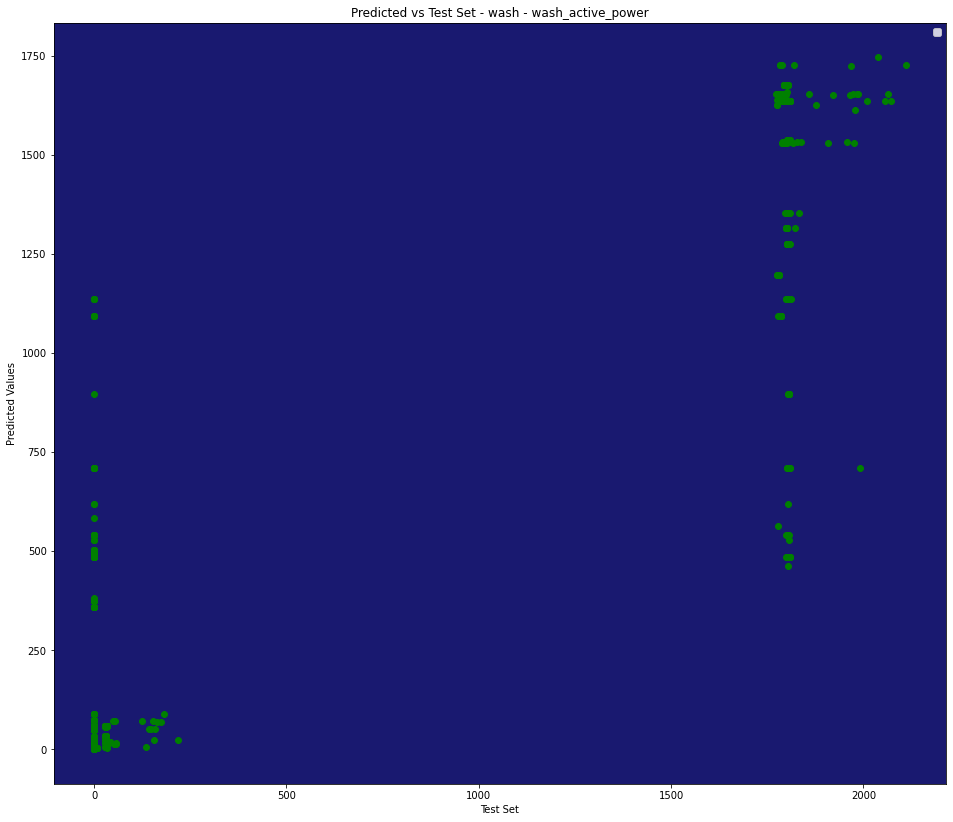

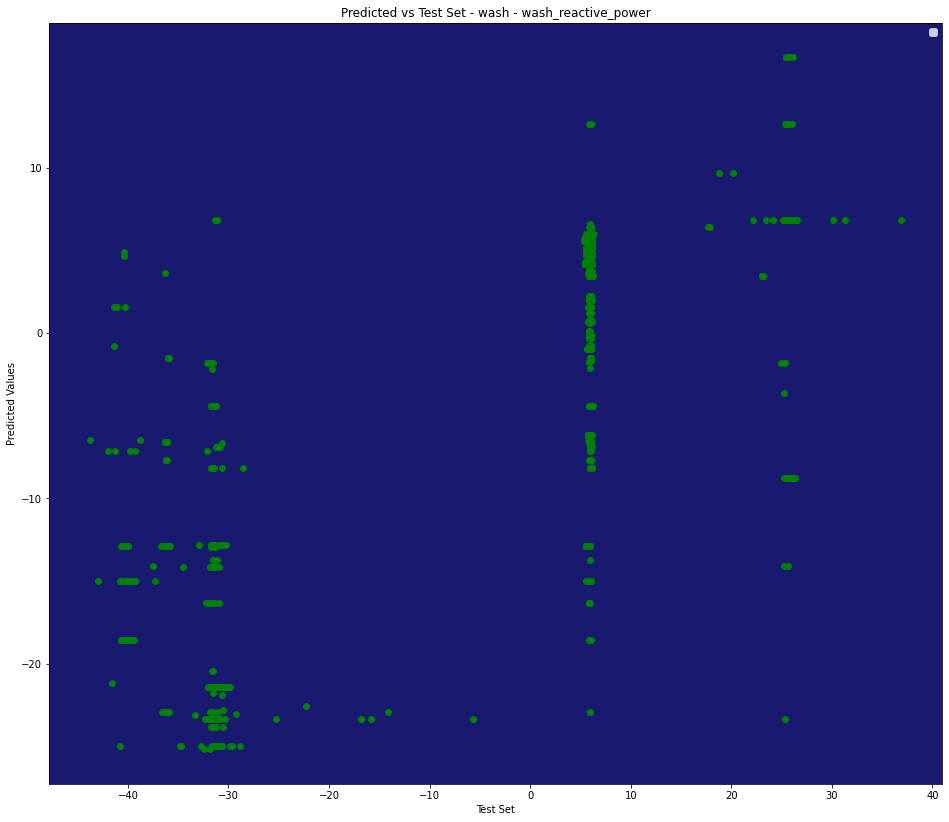

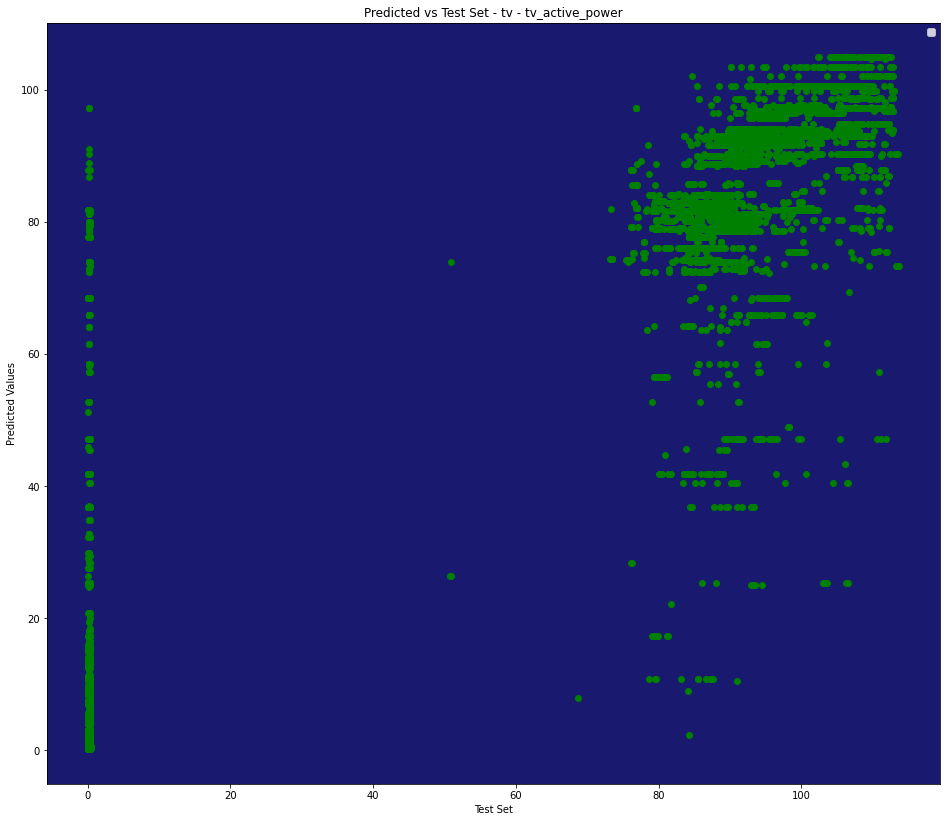

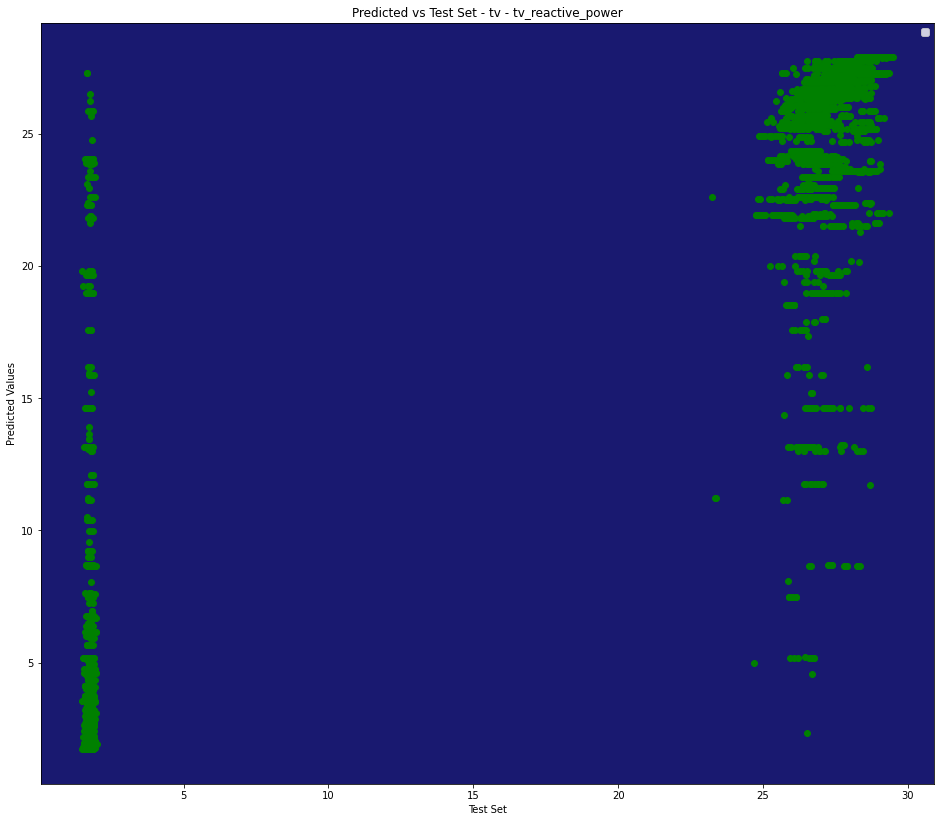

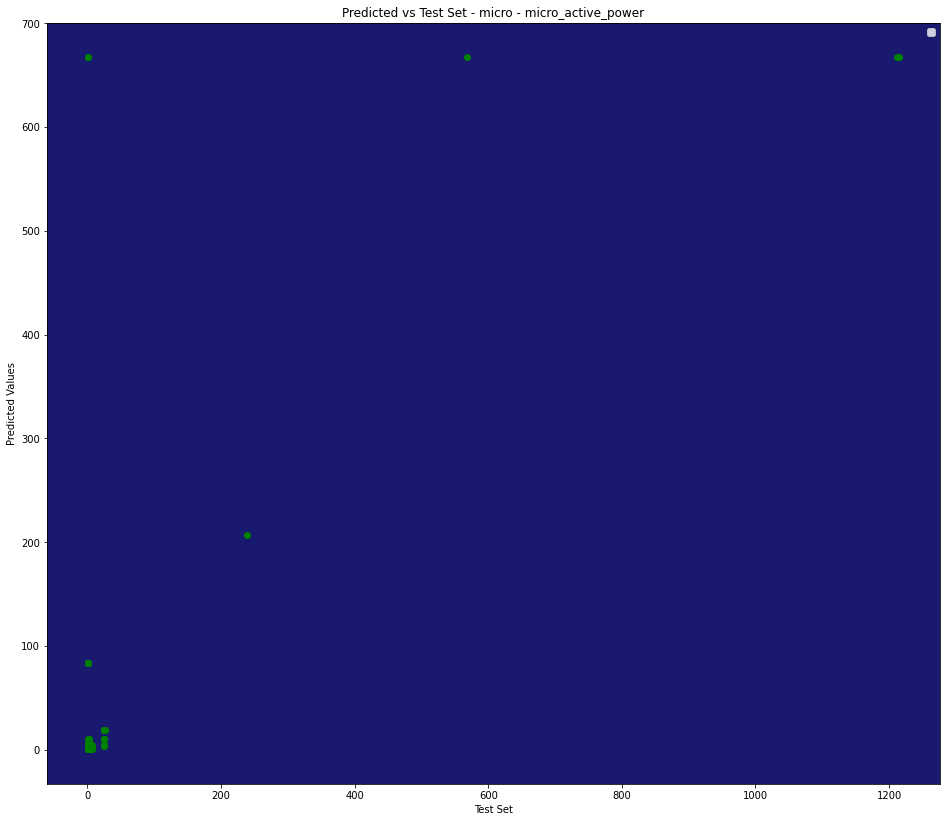

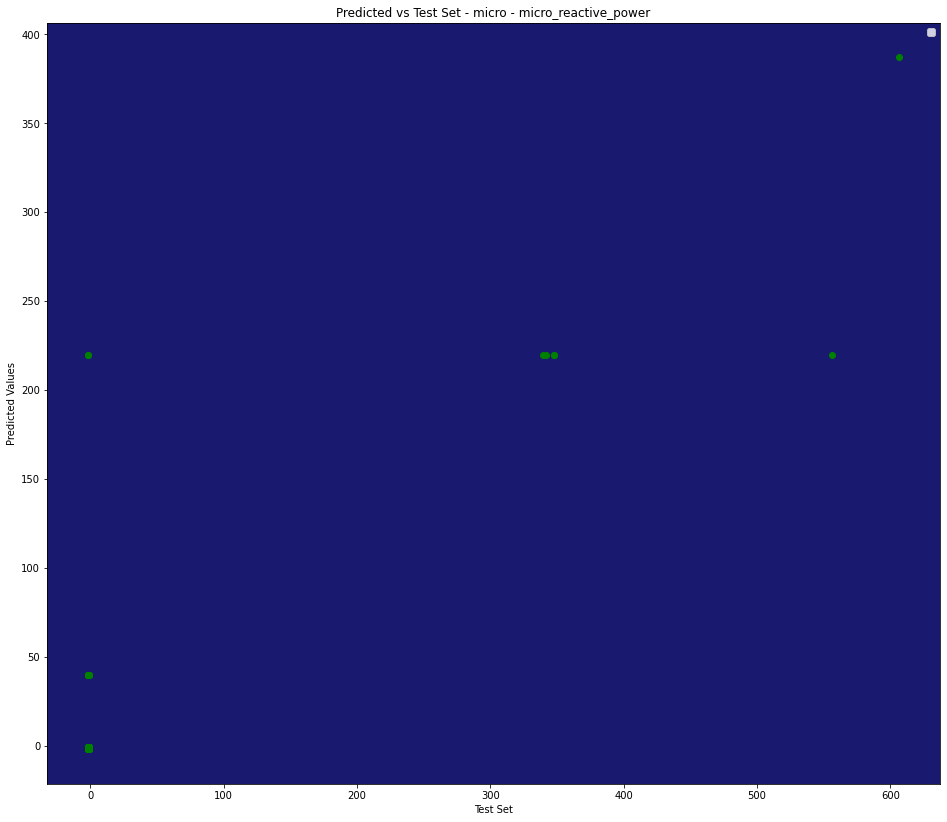

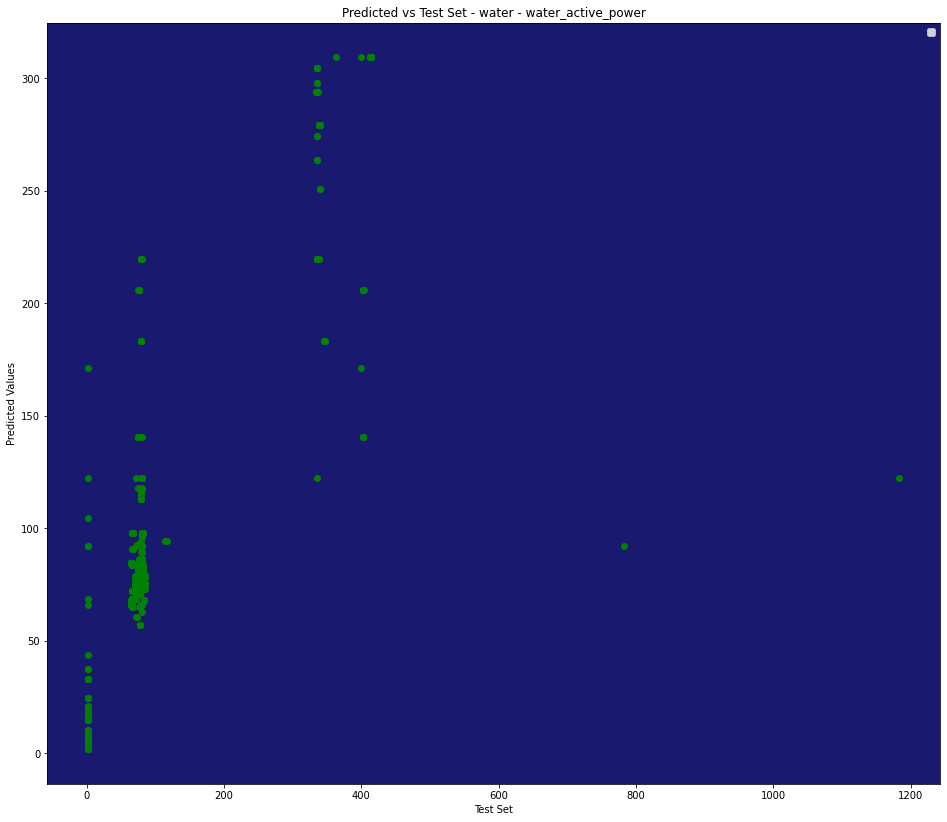

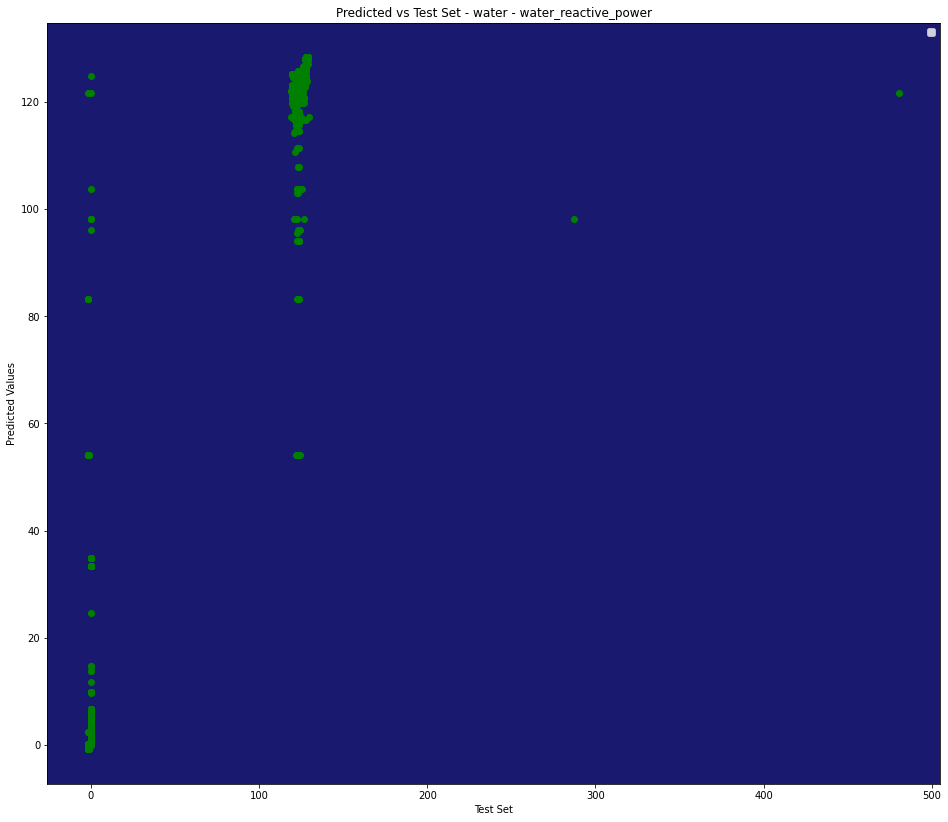

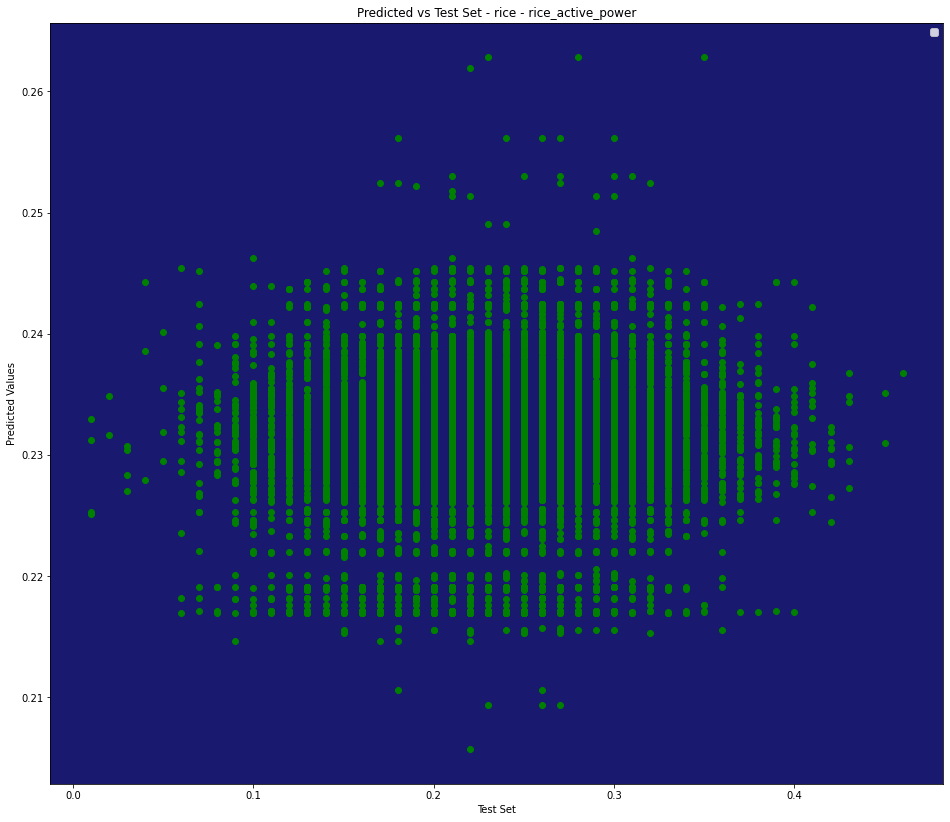

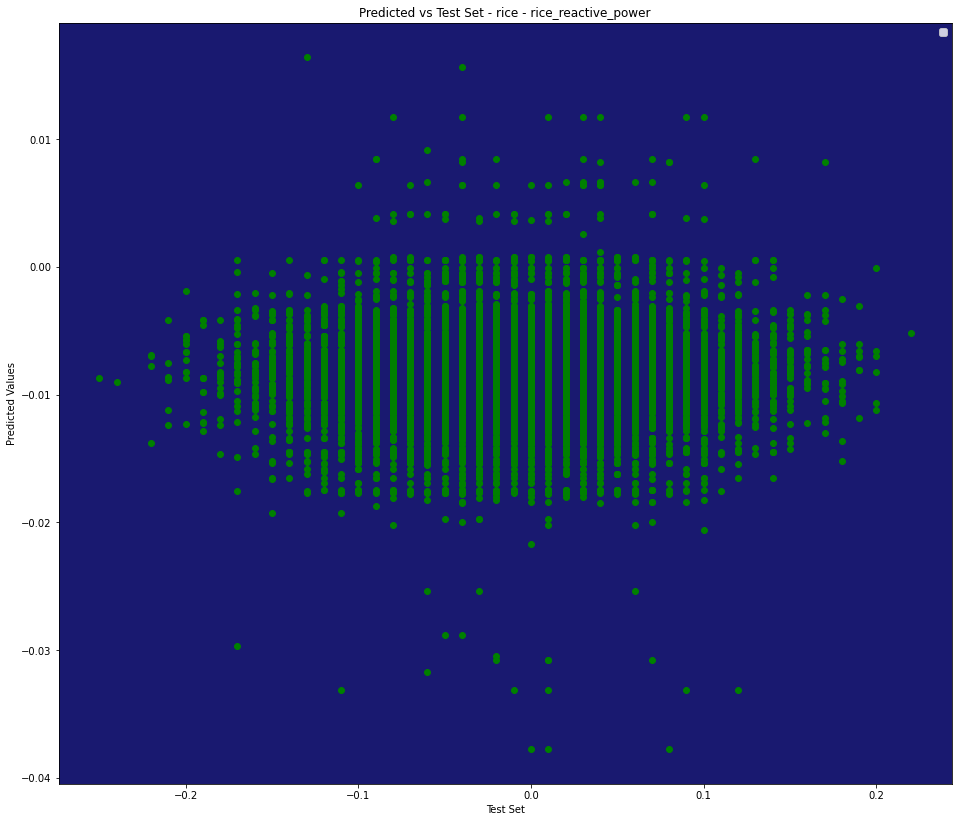

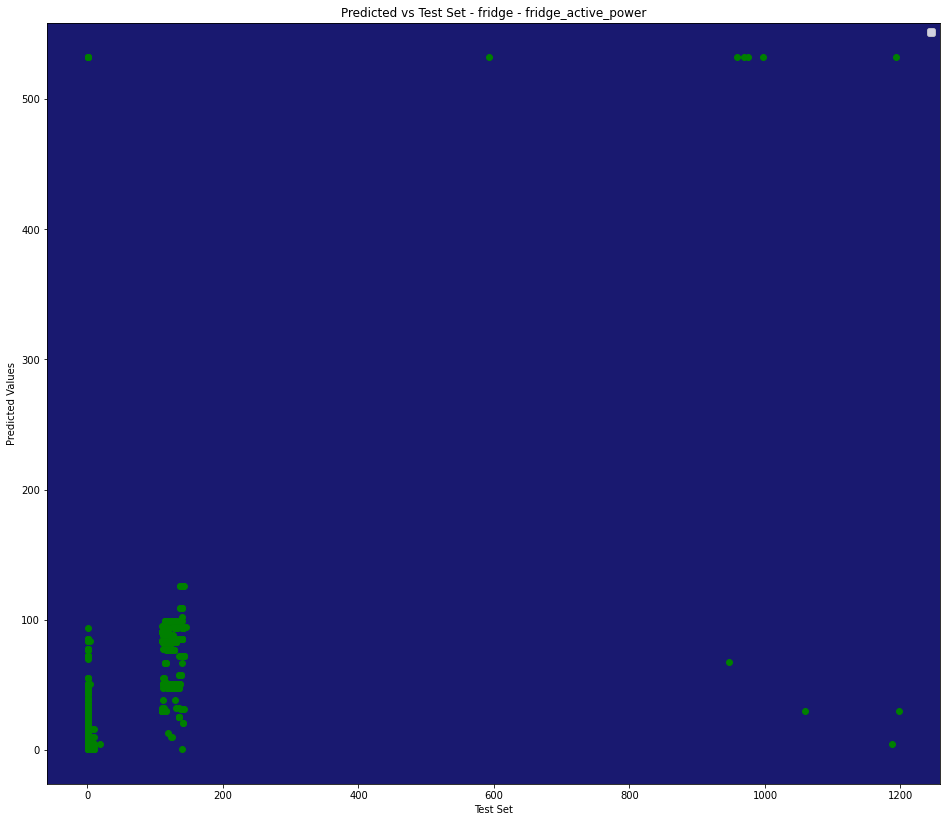

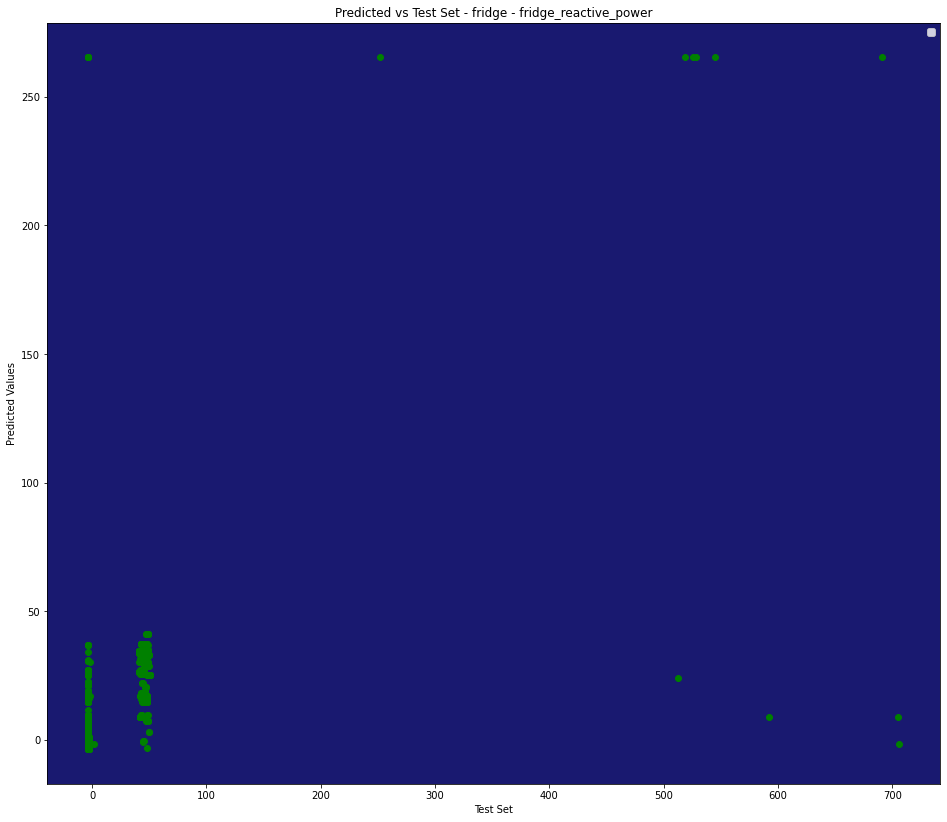

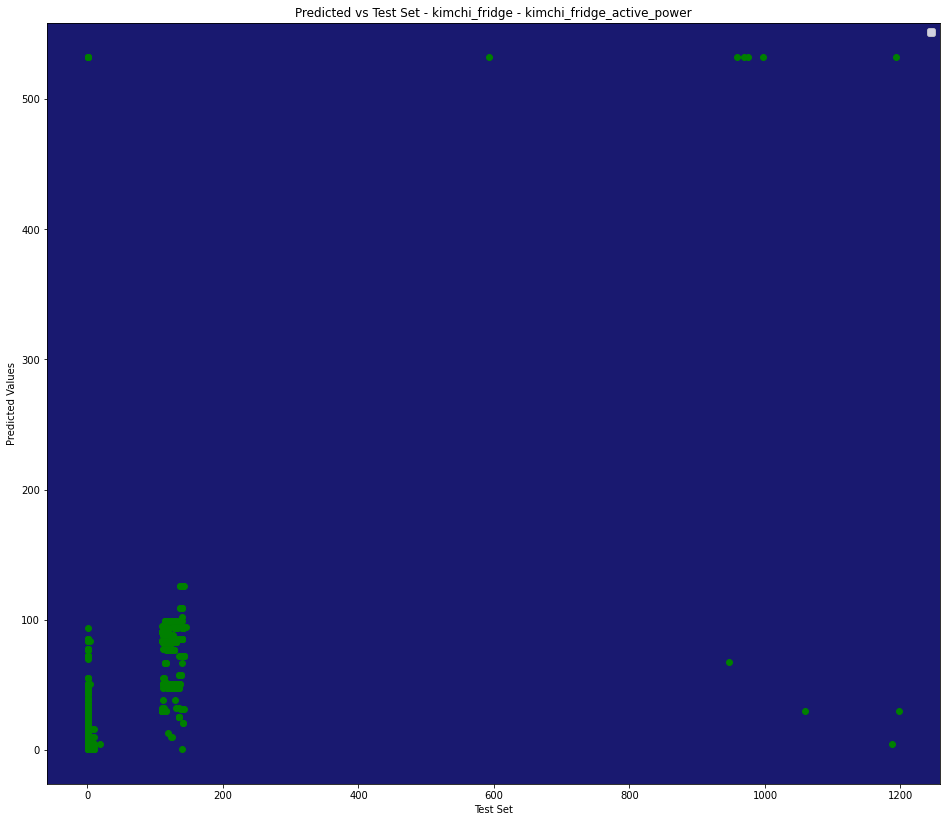

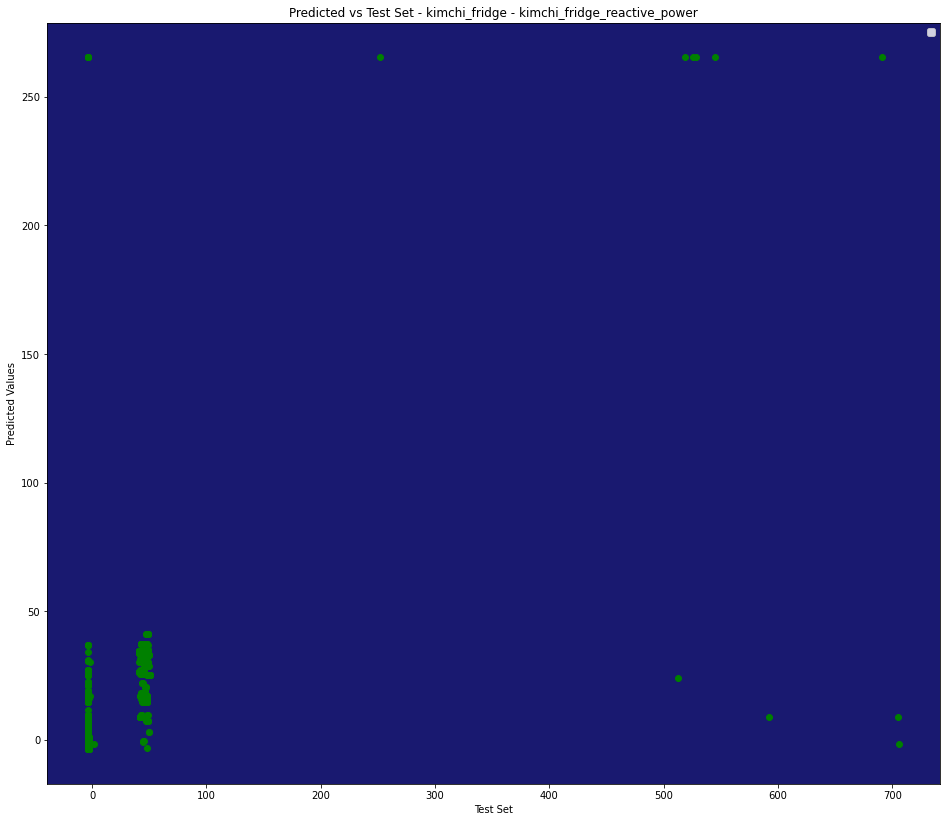

In [32]:
# Iterate over the devices
scatter_color = 'green'

for i, device in enumerate(['wash', 'tv', 'micro', 'water', 'rice','fridge', 'kimchi_fridge']):
    # Iterate over the output columns for the current device
    for j, output_col in enumerate(output_cols[device]):
        # Get the test data and predictions for the current device and output column
        test_values = tests[i][j].select(output_col).collect()
        predicted_values = predictions[device][j].select('prediction').collect()

        # Create a scatter plot for predicted vs test values
        plt.figure(figsize = (16,14))
        plt.scatter(test_values, predicted_values, color = scatter_color)
        plt.xlabel("Test Set")
        plt.ylabel("Predicted Values")
        plt.title(f"Predicted vs Test Set - {device} - {output_col}")
        plt.gca().set_facecolor('midnightblue')  # Change the background color 
        plt.legend()
        plt.show()


In [22]:

trains

[[DataFrame[total_active_power: double, total_reactive_power: double, wash_active_power: double, wash_reactive_power: double],
  DataFrame[total_active_power: double, total_reactive_power: double, wash_active_power: double, wash_reactive_power: double]],
 [DataFrame[total_active_power: double, total_reactive_power: double, tv_active_power: double, tv_reactive_power: double],
  DataFrame[total_active_power: double, total_reactive_power: double, tv_active_power: double, tv_reactive_power: double]],
 [DataFrame[total_active_power: double, total_reactive_power: double, micro_active_power: double, micro_reactive_power: double],
  DataFrame[total_active_power: double, total_reactive_power: double, micro_active_power: double, micro_reactive_power: double]],
 [DataFrame[total_active_power: double, total_reactive_power: double, water_active_power: double, water_reactive_power: double],
  DataFrame[total_active_power: double, total_reactive_power: double, water_active_power: double, water_reacti